## Chapter 2.1 Forward Gravity: Simple example

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline


# Aux imports
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt
import theano
import qgrid

#%matplotlib widget


In [2]:
geo_model = gp.load_model('Greenstone', path= '../data/gempy_models')

In [3]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id,value_0
3,EarlyGranite,EarlyGranite_Series,1,False,#728f02,1,2.61
0,SimpleMafic2,BIF_Series,1,False,#015482,2,2.92
1,SimpleBIF,BIF_Series,2,False,#9f0052,3,3.1
2,SimpleMafic1,SimpleMafic_Series,1,False,#ffbe00,4,2.92
4,basement,Basement,1,True,#443988,5,2.61


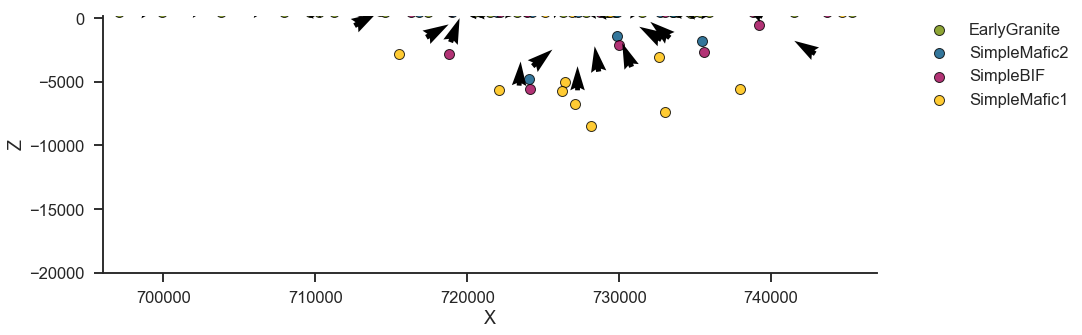

In [4]:
gp.plot.plot_data(geo_model)

In [5]:
# Compute normal model:
# gp.set_interpolation_data(geo_model,
#                           compile_theano=True,
#                           theano_optimizer='fast_compile',
#                           verbose=[])
# gp.compute_model(geo_model)

### Creating grid

First we need to define the location of the devices. For this example we can make a map:

In [6]:
grav_res = 20
X = np.linspace(7.050000e+05, 747000, grav_res)
Y = np.linspace(6863000, 6925000, grav_res)
Z= 300
xyz= np.meshgrid(X, Y, Z)
xy_ravel = np.vstack(list(map(np.ravel, xyz))).T
xy_ravel

array([[7.05000000e+05, 6.86300000e+06, 3.00000000e+02],
       [7.07210526e+05, 6.86300000e+06, 3.00000000e+02],
       [7.09421053e+05, 6.86300000e+06, 3.00000000e+02],
       ...,
       [7.42578947e+05, 6.92500000e+06, 3.00000000e+02],
       [7.44789474e+05, 6.92500000e+06, 3.00000000e+02],
       [7.47000000e+05, 6.92500000e+06, 3.00000000e+02]])

We can see the location of the devices relative to the model data:

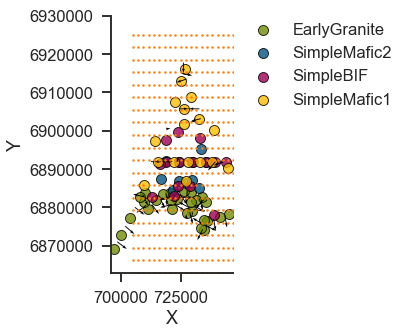

In [7]:
import matplotlib.pyplot as plt
gp.plot.plot_data(geo_model, direction='z')
plt.scatter(xy_ravel[:,0], xy_ravel[:, 1], s=1)

Now we need to create the grid centered on the devices (see: https://github.com/cgre-aachen/gempy/blob/master/notebooks/tutorials/ch1-3-Grids.ipynb)

In [9]:
geo_model.grid.set_centered_grid(xy_ravel,  resolution = [10, 10, 15], radio=5000)
geo_model.grid.deactivate_all_grids()
geo_model.grid.set_active('centered')
geo_model.rescaling.set_rescaled_grid()
geo_model.update_structure(update_theano='matrices')

,values
isLith,True
isFault,False
number faults,0
number surfaces,4
number series,3
number surfaces per series,"[1, 2, 1]"
len surfaces surface_points,"[27, 11, 15, 17]"
len series surface_points,"[27, 26, 17]"
len series orientations,"[26, 2, 13]"


In [10]:
geo_model.grid.centered_grid.kernel_centers

array([[-5000.        , -5000.        ,  -300.        ],
       [-5000.        , -5000.        ,  -360.        ],
       [-5000.        , -5000.        ,  -383.36972966],
       ...,
       [ 5000.        ,  5000.        , -3407.68480754],
       [ 5000.        ,  5000.        , -4618.11403801],
       [ 5000.        ,  5000.        , -6300.        ]])

Now we need to compute the component tz (see https://github.com/cgre-achen/gempy/blob/master/notebooks/tutorials/ch2-2-Cell_selection.ipynb)

In [11]:
from gempy.assets.geophysics import GeophysicsPreprocessing

In [12]:
g = GeophysicsPreprocessing(geo_model.grid.centered_grid)

In [13]:
tz = g.set_tz_kernel()

### Compiling the gravity graph

If geo_model has already a centered grid, the calculation of tz happens automatically. Alternatively you pass tz to `set_gravity interpolator`. This theano graph will return gravity instead the lithologies. In addition we need either to pass the density block (see below). Or the position of density on the surface(in the future the name) to compute the density block at running time.

In [14]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id,value_0
3,EarlyGranite,EarlyGranite_Series,1,False,#728f02,1,2.61
0,SimpleMafic2,BIF_Series,1,False,#015482,2,2.92
1,SimpleBIF,BIF_Series,2,False,#9f0052,3,3.1
2,SimpleMafic1,SimpleMafic_Series,1,False,#ffbe00,4,2.92
4,basement,Basement,1,True,#443988,5,2.61


In this case the densities of each layer are at the loc 1 (0 is the id)

In [15]:
geo_model.set_gravity_interpolator(pos_density=1, verbose=['grid_shape', 'slices'])

Compiling theano function...
Compilation Done!


,values
dtype,float64
output,geology
theano_optimizer,fast_compile
device,cpu
verbosity,"[grid_shape, slices]"


Once we have created a gravity interpolator we can call it from compute model as follows:

In [16]:
grav = gp.compute_model(geo_model, output='gravity')

grid_shape __str__ = [774532]
slices __str__ = [     0 120663 241326 361989 482652 603315 723978 774532]
grid_shape __str__ = [774532]
slices __str__ = [     0 391243 774532]
grid_shape __str__ = [774532]
slices __str__ = [     0 222603 445206 667809 774532]


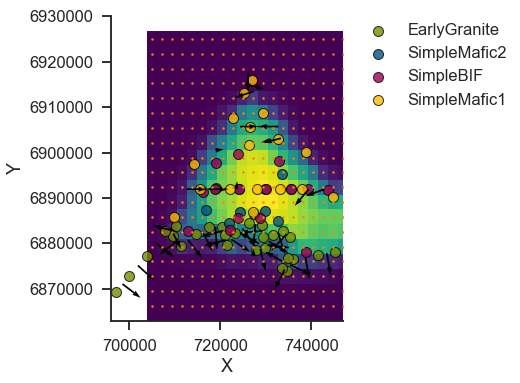

In [17]:
gp.plot.plot_data(geo_model, direction='z', height=7)
plt.scatter(xy_ravel[:,0], xy_ravel[:, 1], s=1)
plt.imshow(grav.reshape(grav_res, grav_res), extent = (xy_ravel[:,0].min() + (xy_ravel[0, 0] - xy_ravel[1, 0])/2,
                                                       xy_ravel[:,0].max() - (xy_ravel[0, 0] - xy_ravel[1, 0])/2,
                                                       xy_ravel[:,1].min() + (xy_ravel[0, 1] - xy_ravel[30, 1])/2,
                                                       xy_ravel[:,1].max() - (xy_ravel[0, 1] - xy_ravel[30, 1])/2),
           cmap='viridis_r', origin='bottom')

#### Plotting lithologies

If we want to compute the lithologies we will need to create a normal interpolator object as seen in the Chapter 1 of the tutorials  

In [18]:
gp.set_interpolation_data(geo_model,
                          compile_theano=True,
                          theano_optimizer='fast_run',
                          verbose=[])

Compiling theano function...
Compilation Done!


Now we want to interpolate on a regular grid for a simple plot. Therefore we need to activate the regular grid:

In [19]:
geo_model.grid.set_active('regular')
geo_model.grid.set_inactive('centered')
geo_model.rescaling.set_rescaled_grid()
geo_model.update_structure(update_theano='matrices')

,values
isLith,True
isFault,False
number faults,0
number surfaces,4
number series,3
number surfaces per series,"[1, 2, 1]"
len surfaces surface_points,"[27, 11, 15, 17]"
len series surface_points,"[27, 26, 17]"
len series orientations,"[26, 2, 13]"


In [20]:
gp.compute_model(geo_model)


Lithology ids 
  [5. 5. 5. ... 5. 5. 5.] 

Now we can plot all together (change the alpha parameter to see the gravity overlying):

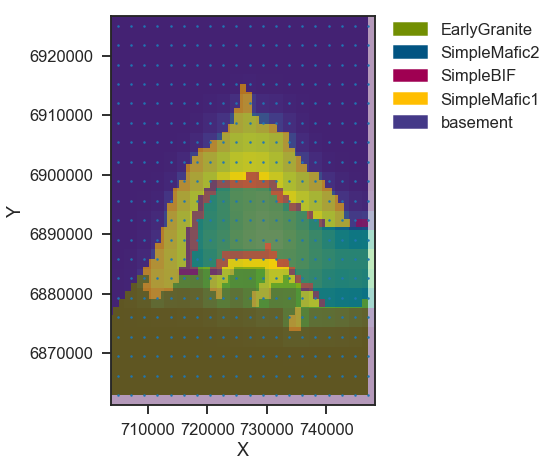

In [21]:
gp.plot.plot_section(geo_model, -1, direction='z')
plt.scatter(xy_ravel[:,0], xy_ravel[:, 1], s=1)
plt.imshow(grav.reshape(grav_res, grav_res), extent = (xy_ravel[:,0].min() + (xy_ravel[0, 0] - xy_ravel[1, 0])/2,
                                                       xy_ravel[:,0].max() - (xy_ravel[0, 0] - xy_ravel[1, 0])/2,
                                                       xy_ravel[:,1].min() + (xy_ravel[0, 1] - xy_ravel[30, 1])/2,
                                                       xy_ravel[:,1].max() - (xy_ravel[0, 1] - xy_ravel[30, 1])/2),
           cmap='viridis_r', origin='bottom', alpha=.4)

### Computing gravity by passing the density block.

We may have computed the densities on a previous step and we want to compute gravity afterwards. First lets compute the density block on a centered grid:

In [22]:
geo_model.grid.set_inactive('regular')
geo_model.grid.set_active('centered')
geo_model.rescaling.set_rescaled_grid()
geo_model.update_structure(update_theano='matrices')

,values
isLith,True
isFault,False
number faults,0
number surfaces,4
number series,3
number surfaces per series,"[1, 2, 1]"
len surfaces surface_points,"[27, 11, 15, 17]"
len series surface_points,"[27, 26, 17]"
len series orientations,"[26, 2, 13]"


In [23]:
geo_model.grid.length

array([     0,      0,      0,      0, 774400])

In [24]:
sol = gp.compute_model(geo_model, set_solutions=False)

In [25]:
l0, l1 = geo_model.grid.get_grid_args('centered')
sol[0][1][l0:l1]

array([2.61, 2.61, 2.61, ..., 2.61, 2.61, 2.61])

Notice that since the heavy computations have been already carried on the compilation of the graph and the evaluation of the gravity is rather fast!

In [26]:
geo_model.set_gravity_interpolator(density_block=sol[0][1][l0:l1])

Compiling theano function...
Compilation Done!


,values
dtype,float64
output,geology
theano_optimizer,fast_run
device,cpu
verbosity,[]


In [27]:
grav_shared = gp.compute_model(geo_model, output='gravity')

In [28]:
# We check that the results are the same as we got before:
(grav != grav_shared).sum()

0